In [1]:
from functools import partial
import os
import argparse
import yaml

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from guided_diffusion.condition_methods import get_conditioning_method
from guided_diffusion.measurements import get_noise, get_operator
from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion_correct import create_sampler
from data.dataloader import get_dataset, get_dataloader
from util.img_utils import clear_color, mask_generator
from util.logger import get_logger
from common_utils import *
from ddim_sampler import *
import shutil
import lpips

/home/shijun.liang/ENTER/envs/transform/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_yaml(file_path: str) -> dict:
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config

model_config='/home/shijun.liang/github_code/diffusion-posterior-sampling-main/configs/model_config.yaml'
diffusion_config='/home/shijun.liang/github_code/diffusion-posterior-sampling-main/configs/diffusion_config.yaml'
task_config= '/home/shijun.liang/github_code/diffusion-posterior-sampling-main/configs/super_resolution_config.yaml'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load configurations
model_config = load_yaml(model_config)
diffusion_config = load_yaml(diffusion_config)
task_config = load_yaml(task_config)

In [3]:
model = create_model(**model_config)
model = model.to(device)
model.eval()

# Prepare Operator and noise
measure_config = task_config['measurement']
operator = get_operator(device=device, **measure_config['operator'])
noiser = get_noise(**measure_config['noise'])
#logger.info(f"Operation: {measure_config['operator']['name']} / Noise: {measure_config['noise']['name']}")

# Prepare conditioning method
cond_config = task_config['conditioning']
cond_method = get_conditioning_method(cond_config['method'], operator, noiser, **cond_config['params'])
measurement_cond_fn = cond_method.conditioning
#logger.info(f"Conditioning method : {task_config['conditioning']['method']}")

# Load diffusion sampler
sampler = create_sampler(**diffusion_config) 
sample_fn = partial(sampler.p_sample_loop, model=model, measurement_cond_fn=measurement_cond_fn)

# Working directory
out_path = os.path.join('/home/shijun.liang/github_code/diffusion-posterior-sampling-main/result')


# Prepare dataloader
data_config = task_config['data']
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = get_dataset(**data_config, transforms=transform)
loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

# Exception) In case of inpainting, we need to generate a mask 
if measure_config['operator']['name'] == 'inpainting':
    mask_gen = mask_generator(
       **measure_config['mask_opt']
    )



In [4]:
mask = torch.ones(1,3,256,256)
mask[:,:,70:200,70:190]=0  #define mask
mask = mask.to(device)
scheduler = DDIMScheduler()

In [5]:
def mask_A(image,mask):
   return (image*mask).to(device)


In [6]:
def optimize_input(input,  sqrt_one_minus_alpha_cumprod, sqrt_alpha_cumprod, t, num_steps=100, learning_rate=0.01):
    input_tensor = torch.randn(1, model.in_channels, 256, 256, requires_grad=True)
    input_tensor.data = input.clone().to(device)
    optimizer = torch.optim.Adam([input_tensor], lr=.01)
    tt = (torch.ones(1) * t).to(device)
    for step in range(num_steps):
        optimizer.zero_grad()
       
        noise_pred = model(input_tensor.to(device), tt)
        noise_pred = noise_pred[:, :3]
        pred_x0 = (input_tensor.to(device) -sqrt_one_minus_alpha_cumprod * noise_pred) / sqrt_alpha_cumprod
        pred_x0= torch.clamp(pred_x0, -1, 1)
        #print(operator.forward(pred_x0).shape)
        #print(y_n.shape)
        out =operator.forward(pred_x0)
        loss = torch.norm(out-y_n)**2+1.5*torch.norm(input-input_tensor)
        #loss = torch.norm(noiser(mask_A(pred_x0,mask))-y_n)
        loss.backward(retain_graph=True)    
        #loss.backward()
        optimizer.step()

      #  print(f"Step {step}/{num_steps}, Loss: {loss.item()}")
    noise = (input_tensor-sqrt_alpha_cumprod*pred_x0)/sqrt_one_minus_alpha_cumprod
    return input_tensor.detach(), pred_x0.detach(), noise.detach()

In [7]:
out = []
n_step = 20
scheduler.set_timesteps(num_inference_steps=n_step)
step_size = 1000//n_step

In [8]:
dtype = torch.float32

In [9]:
gt_img = Image.open('/home/shijun.liang/github_code/diffusion-posterior-sampling-main/00000.png').convert("RGB")
#shutil.copy(gt_img_path, os.path.join(logdir, 'gt.png'))
ref_numpy = np.array(gt_img).astype(np.float32) / 255.0
x = ref_numpy * 2 - 1
x = x.transpose(2, 0, 1)
ref_img = torch.Tensor(x).to(dtype).to(device).unsqueeze(0)
ref_img.requires_grad = False
ref_img = ref_img.to(device)
if measure_config['operator'] ['name'] == 'inpainting':
    mask = mask
    measurement_cond_fn = partial(cond_method.conditioning, mask=mask)
    sample_fn = partial(sample_fn, measurement_cond_fn=measurement_cond_fn)

    # Forward measurement model (Ax + n)
    y = operator.forward(ref_img, mask=mask)
    y_n = noiser(y)

else: 
    # Forward measurement model (Ax + n)
    y = operator.forward(ref_img)
    y_n = noiser(y)
#y_n.requires_grad = False

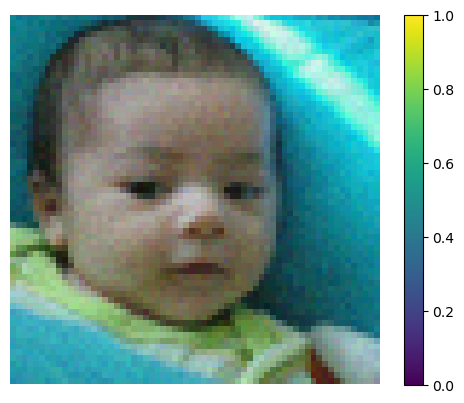

In [10]:
plt.imshow(clear_color(y_n))
plt.axis('off')
plt.colorbar()

In [11]:
#input = y.clone()
input =torch.randn((1, 3, 256, 256), device=device, dtype=dtype)
noise = torch.randn(input.shape)*((1-scheduler.alphas_cumprod[-1])**0.5)
input = torch.tensor(input)*((scheduler.alphas_cumprod[-1])**0.5) + noise.to(device)
for i, t in enumerate(scheduler.timesteps):
        prev_timestep = t - step_size

        alpha_prod_t = scheduler.alphas_cumprod[t]
        alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.alphas_cumprod[0]

        beta_prod_t = 1 - alpha_prod_t
        sqrt_one_minus_alpha_cumprod = beta_prod_t**0.5
      
        #input, pred_original_sample, noise_pred= optimize_input(input.clone(),sqrt_one_minus_alpha_cumprod, alpha_prod_t**0.5, t, num_steps=5, learning_rate=0.01)
        #input = pred_original_sample * alpha_prod_t_prev**0.5+ (1-alpha_prod_t_prev)**0.5*torch.randn(input.size()).to(device)
        for k in range(1):
            input, pred_original_sample, noise_pred= optimize_input(input.clone(), sqrt_one_minus_alpha_cumprod, alpha_prod_t**0.5, t, num_steps=30, learning_rate=0.01)
            input= pred_original_sample * alpha_prod_t**0.5+(1-alpha_prod_t)**0.5*torch.randn(input.size()).to(device)
        input = pred_original_sample * alpha_prod_t_prev**0.5+(1-alpha_prod_t_prev)**0.5*torch.randn(input.size()).to(device)
   
        
        print(f"Time: {t}")
input = (input/2+0.5).clamp(0, 1)
#input = (input + 1) / 2
inpainted_image = input.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

/tmp/ipykernel_100999/3439172987.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)*((scheduler.alphas_cumprod[-1])**0.5) + noise.to(device)


Time: 950
Time: 900
Time: 850
Time: 800
Time: 750
Time: 700
Time: 650
Time: 600
Time: 550
Time: 500
Time: 450
Time: 400
Time: 350
Time: 300
Time: 250
Time: 200
Time: 150
Time: 100
Time: 50
Time: 0


In [12]:
y = (y/2+0.5)

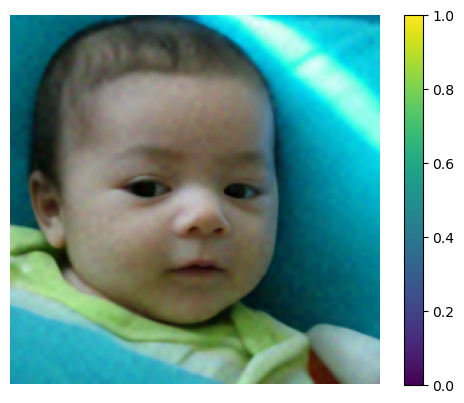

In [13]:
plt.imshow(inpainted_image)
plt.axis('off')
#plt.savefig("ffhq0000_db2.png", dpi=300,bbox_inches='tight', pad_inches=0)
plt.colorbar()

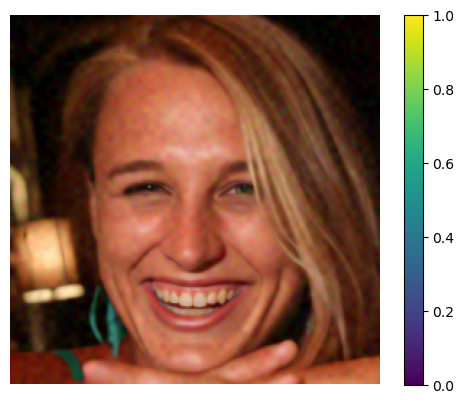

In [14]:
plt.imshow(inpainted_image)
plt.axis('off')
#plt.savefig("ffhq0000_db2.png", dpi=300,bbox_inches='tight', pad_inches=0)
plt.colorbar()

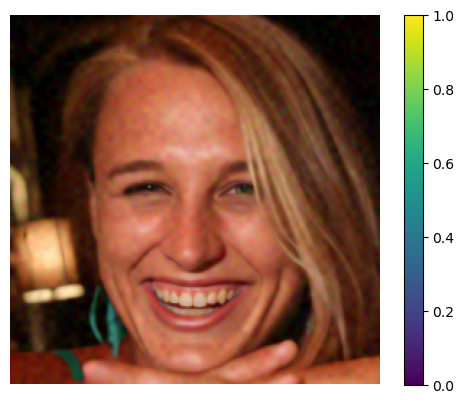

In [15]:
plt.imshow(inpainted_image)
plt.axis('off')
plt.savefig("ffhq0000_linear_gb4.png", dpi=300,bbox_inches='tight', pad_inches=0)
plt.colorbar()

In [14]:
gt = (ref_img/2+0.5)

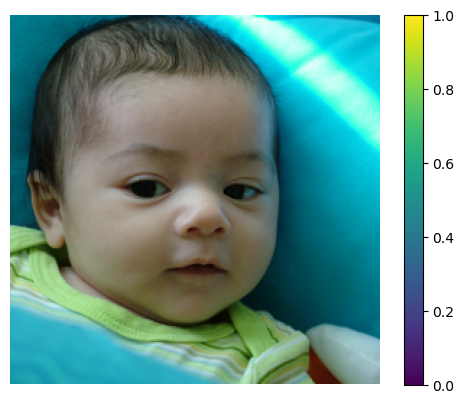

In [15]:
plt.imshow(np.array(gt.cpu().detach().numpy()[0].transpose(1,2,0)))
plt.axis('off')
plt.colorbar()

In [16]:
def compute_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Assuming the image is normalized to [0, 1]
    psnr = 20 * np.log10(max_pixel / (mse**0.5))
    return psnr.item()
psnr_value = compute_psnr(np.array(inpainted_image), np.array(gt.cpu().detach().numpy()[0].transpose(1,2,0)))
print(f"After diffusion PSNR: {psnr_value} dB")


After diffusion PSNR: 30.28341634791284 dB


In [25]:
print(input.shape)

torch.Size([1, 3, 256, 256])


In [17]:
from piq import psnr, ssim, LPIPS

In [18]:
def norm( x):
    return (x * 0.5 + 0.5).clip(0, 1)

In [19]:
print(psnr(norm(ref_img), norm(input), 1.0, reduction='mean'))

tensor(10.0113, device='cuda:0')


In [8]:
fname = str(i).zfill(5) + 'test'

In [9]:
np.save(os.path.join(out_path, 'mask', fname), mask.cpu().detach().numpy())
np.save(os.path.join(out_path, 'input', fname), y_n.cpu().detach().numpy())
np.save(os.path.join(out_path, 'label', fname), ref_img.cpu().detach().numpy())
np.save(os.path.join(out_path, 'recon', fname), sample.cpu().detach().numpy())